# Systemic risk assessment


In [1]:
# Importing packages

import geopandas as gpd
import pandas as pd
import os
import rioxarray as rio
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
from scipy.interpolate import interp1d
from table import sut_basic
from mria_new_SUT import MRIA_SUT as MRIAnew
from pyomo.environ import value

#### Reading the inputs

The first step of the analysis is to read the inputs to the required input data.


In [2]:
input_path = "C:/Users/sva100/OneDrive - Vrije Universiteit Amsterdam/PhD/Codes and Methods/Paper1/Codes/Misc/06_Complete_framework_Zuid Holland/data"

# Critical Infrastructure - Substations
substations = gpd.read_file(os.path.join(input_path, "substaions_nl33.shp"))

# Industrial Sites
industries = gpd.read_file(os.path.join(input_path, "is_nl33.shp"))

# Agricultural sites
agri = gpd.read_file(os.path.join(input_path, "agri_zh.shp"))

# Commercial sectors from places API
commercial = gpd.read_file(os.path.join(input_path, "I_H53.shp"))

#### Industrial sectors from places API
industrial = gpd.read_file(os.path.join(input_path, "C19_C20_C24.shp"))

# shape file
nl_nuts = gpd.read_file(os.path.join(input_path, "nutsnl_roe.shp"))

# damage model
dam_model = pd.read_excel(os.path.join(input_path, "Dam_Fun_models.xlsx"))

# Hazard map
flood_map = rio.open_rasterio(os.path.join(input_path, "rotterdam_event.tif"))

# List of sectors
sectors = pd.read_excel(os.path.join(input_path, "sectors.xlsx"))

# region of disaster
rod = "NL33"

#### Step 1: Input preparation.

a. Creating a unified exposure dataframe, containing the following columns:

- Sector code
- Damage model
- Geometry

For industrial sites sector code will be given as ADA - refering to the area distribution array

b. Creating the area distribution array for industrial sectors


##### Unified exposure dataframe


In [3]:
def data_prep_agri(agri, damage_model, sector_code):
    agri_geom = gpd.GeoDataFrame(agri["geometry"])
    agri_geom["dam_model"] = damage_model
    agri_geom["sector_code"] = sector_code
    agri_geom["osmid"] = "N/A"
    return agri_geom


def data_prep_ind(agri, damage_model, sector_code):
    agri_geom = gpd.GeoDataFrame(agri["geometry"])
    agri_geom["dam_model"] = damage_model
    agri_geom["sector_code"] = sector_code
    agri_geom["osmid"] = agri["osmid"]
    return agri_geom


def data_prep_com(commercial):
    commercial_geom = gpd.GeoDataFrame(commercial["geometry"])
    commercial_geom["dam_model"] = "Commercial"
    commercial_geom["sector_code"] = commercial["Sector_id"]
    commercial_geom["osmid"] = "N/A"

    for i in range(len(commercial_geom)):
        # For hotels, buffer radius of 50 m
        if commercial_geom.loc[i, "sector_code"] == "I":
            commercial_geom.loc[i, "geometry"] = commercial_geom.loc[
                i, "geometry"
            ].centroid.buffer(50 * 0.000009090)

        # For postal and courier services , buffer radisu of 15 m
        else:
            commercial_geom.loc[i, "geometry"] = commercial_geom.loc[
                i, "geometry"
            ].centroid.buffer(20 * 0.000009090)

    return commercial_geom

In [4]:
agri_new = data_prep_agri(agri, "Agricultural", "A01")
industries_new = data_prep_ind(industries, "Industrial", "ADA")
commercial_new = data_prep_com(commercial)

exposure = pd.concat([agri_new, commercial_new, industries_new])
exposure = exposure.reset_index(drop=True)

##### Area distribution array


In [5]:
def create_area_df(industries, industrial):
    # Intersection polygons b/w OSM industrial sites and places api industries
    intersected_polygons = gpd.overlay(industrial, industries, how="intersection")

    ind_list = list(industrial.Sector_id.unique())
    ind_list.append("Other")

    # Iniitalising some numpy arrays
    count_array = np.zeros((len(industries), len(ind_list) + 1))
    area_array = np.zeros((len(industries), len(ind_list) + 1))

    # COunting the number of industries of each sectors in each site
    for i in range(len(industries)):
        osmid = industries.loc[i, "osmid"]
        count_array[i, 0] = osmid
        ip = intersected_polygons[intersected_polygons["osmid"] == osmid]

        for j in range(len(ind_list)):
            x = ip[ip["Sector_id"] == ind_list[j]]
            count_array[i, j + 1] = len(x)

    # Distributing the area of an industrial site based on the number of idnustries each scetor has
    # If an industrial site is unoccupied, the area is distributed equally among all sectors

    for i in range(len(industries)):
        osmid = industries.loc[i, "osmid"]
        area_array[i, 0] = osmid
        ip = industries[industries["osmid"] == osmid]
        area = ip.loc[i, "geometry"].area
        row_sum = np.sum(count_array[i, 1:])

        for j in range(len(ind_list)):
            if row_sum > 0:
                area_array[i, j + 1] = (count_array[i, j + 1] / (row_sum)) * area
            else:
                area_array[i, j + 1] = 0
                # area_array[i,j+1] = area / len(ind_list)

    # Creating a datafrtame of area array
    area_df = pd.DataFrame(area_array)
    col_list = ["osmid"]
    for i in range(len(ind_list)):
        col_list.append(ind_list[i])
    area_df.columns = col_list

    return area_df

In [33]:
area_df = create_area_df(industries, industrial)

#### Step 2: Estimate damages / functionality loss


In [7]:
# Inputs
# vector = geodataframe of substations, industrial sites etc.
# raster =  floodmaps
# org_crs = the initial crs of the vector


def depth_calculator(vector, raster):
    # CRS consistency between the vector and the raster
    vector = vector.to_crs(raster.rio.crs)

    # Converting no data (i.e., no inundationvalues) to zero
    raster = raster.where(flood_map != flood_map.rio.nodata, 0)

    # Calucate the maximum inundation depth within each polygon
    stats = zonal_stats(
        vector, raster[0].values, affine=raster.rio.transform(), stats="mean"
    )

    # Create a new column depth and if the stat is None (i.e., the polygon is outside the raster extent) we make the depth zero
    vector["depth"] = [
        stat["mean"] if stat["mean"] is not None else 0 for stat in stats
    ]

    return vector

##### Flood depths at the exposure locations and substations


In [8]:
exposure = depth_calculator(exposure, flood_map)
substations = depth_calculator(substations, flood_map)

C:\Users\sva100\AppData\Local\miniforge3\envs\mria\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


##### Estimating damage ratios (for Agri) and probability of being functional foexpsoure and substations


In [9]:
def damage_functionalityloss_exposure(exposure, dam_model):
    for i in range(len(exposure)):
        depth = exposure.loc[i, "depth"]
        dam_class = exposure.loc[i, "dam_model"]

        interp_func = interp1d(
            dam_model["Depth"],
            dam_model[dam_class],
            kind="linear",
            fill_value="extrapolate",
        )
        ratio = interp_func(depth)
        exposure.loc[i, "dr/pf"] = ratio

        if dam_class == "Agricultural":
            exposure.loc[i, "fun_state"] = ratio

        else:
            # Random number 1
            # if ratio <= np.random.uniform(0,1):
            if ratio <= 0.5:
                exposure.loc[i, "fun_state"] = 0
            else:
                exposure.loc[i, "fun_state"] = 1

    return exposure


def functionalityloss_substations(exposure, dam_model):
    for i in range(len(exposure)):
        depth = exposure.loc[i, "depth"]
        dam_class = "Substations"

        interp_func = interp1d(
            dam_model["Depth"],
            dam_model[dam_class],
            kind="linear",
            fill_value="extrapolate",
        )
        ratio = interp_func(depth)
        exposure.loc[i, "dr/pf"] = ratio

        # Random number 2
        # if ratio <= np.random.uniform(0,1):
        if ratio <= 0.5:
            exposure.loc[i, "fun_state"] = 0
        else:
            exposure.loc[i, "fun_state"] = 1

    return exposure

In [10]:
exposure = damage_functionalityloss_exposure(exposure, dam_model)
substations = functionalityloss_substations(substations, dam_model)

#### Step 3: Linking the exposure and substations from which they receive power


In [11]:
# The function to sort the substations based on closet proximity to the sites of interest
def sort_df(gdf_polygon, gdf_points):
    nearest_points_series = gdf_points.geometry.apply(
        lambda x: gdf_polygon.geometry.iloc[0].distance(x)
    )
    sorted_points_df = gdf_points.assign(
        distance_to_polygon=nearest_points_series
    ).sort_values(by="distance_to_polygon")
    sorted_points_df["rank"] = range(1, len(sorted_points_df) + 1)
    return sorted_points_df


def substation_assignemnet(expsoure, substations, p):
    # Conevrting the substtions to a points dataframe
    ss_pts = substations
    ss_pts["geometry"] = substations["geometry"].centroid

    for sr in range(len(expsoure)):
        soi = exposure.iloc[sr]
        soi = soi.to_frame().T
        soi = soi.reset_index(drop=True)

        if soi.loc[0, "dam_model"] == "Agricultural":
            expsoure.loc[sr, "substation_osm"] = 0

        else:
            # Sorting the substations based on closest proximity to the site
            sorted_df = sort_df(soi, ss_pts)
            sorted_df = sorted_df.reset_index(drop=True)

            for i in range(len(sorted_df)):
                rank = sorted_df.loc[i, "rank"]
                prob_new = ((1 - p) ** (rank - 1)) * p
                sorted_df.loc[i, "probability"] = prob_new

            # Multiplying probability with voltage as weights
            sorted_df["probxweight"] = (
                sorted_df["probability"] * sorted_df["voltage_kv"]
            )

            # Calculating weighted probabilities
            sorted_df["weigh_prob"] = (
                sorted_df["probxweight"] / sorted_df["probxweight"].sum()
            )

            # Deriving cumulative probabilities
            sorted_df.loc[0, "cum_prob"] = sorted_df.loc[0, "weigh_prob"]

            for i in range(len(sorted_df) - 1):
                sorted_df.loc[i + 1, "cum_prob"] = (
                    sorted_df.loc[i + 1, "weigh_prob"] + sorted_df.loc[i, "cum_prob"]
                )

            # Selecting a substation based on a uniformly distributed random number
            # Random number - 2
            # r = np.random.rand()
            r = 0.5
            selected_row = sorted_df[sorted_df["cum_prob"] >= r].iloc[0]
            expsoure.loc[sr, "substation_osm"] = selected_row.osmid

    return expsoure

In [12]:
# The parameter p = 0.8 is the parameter of the geometric distribuion used in the assignment
exposure = substation_assignemnet(exposure, substations, 0.8)

#### Step 4: Revising the functional states based on the functional state of the substation


In [13]:
substations.head()

,osmid,voltage_kv,geometry,depth,dr/pf,fun_state
0,23135620,50.0,POINT (73217.138 418220.725),0.865419,0.0,0.0
1,921069367,50.0,POINT (82164.613 433185.430),0.000000,1.0,1.0
2,146901292,150.0,POINT (77728.298 428458.544),0.038460,1.0,1.0
3,920938651,50.0,POINT (78855.868 431086.334),0.000000,1.0,1.0
4,23135699,50.0,POINT (78919.962 431108.331),0.023571,1.0,1.0


In [14]:
def functionality_modifier(exposure, substations):
    for i in range(len(exposure)):
        # Filtering the expsoure site of interest
        soi = exposure.iloc[i]
        soi = soi.to_frame().T
        soi = soi.reset_index(drop=True)

        if soi.loc[0, "dam_model"] == "Agricultural":
            exposure.loc[i, "fun_state_re"] = exposure.loc[i, "dr/pf"]

        else:
            # Osm id of the connected substation
            osm_ss = soi.loc[0, "substation_osm"]

            # Functionality state of the substation
            ss_i = substations[substations["osmid"] == osm_ss]
            ss_i = ss_i.reset_index(drop=True)
            new_fun = ss_i.loc[0, "fun_state"] * soi.loc[0, "fun_state"]
            exposure.loc[i, "fun_state_re"] = new_fun

    return exposure

In [15]:
exposure = functionality_modifier(exposure, substations)

In [16]:
exposure.head()

,geometry,dam_model,sector_code,osmid,depth,dr/pf,fun_state,substation_osm,fun_state_re
0,"POLYGON ((88729.433 415611.611, 89030.707 4156...",Agricultural,A01,N/A,0.962088,0.40711,0.40711,0.0,0.40711
1,"POLYGON ((104019.310 420612.951, 104041.389 42...",Agricultural,A01,N/A,0.000000,0.00000,0.00000,0.0,0.00000
2,"POLYGON ((106726.610 421939.862, 106541.554 42...",Agricultural,A01,N/A,0.000000,0.00000,0.00000,0.0,0.00000
3,"POLYGON ((116336.538 423646.615, 116263.008 42...",Agricultural,A01,N/A,0.000000,0.00000,0.00000,0.0,0.00000
4,"POLYGON ((110388.815 424149.455, 110909.941 42...",Agricultural,A01,N/A,0.000000,0.00000,0.00000,0.0,0.00000


#### Step 5: Estimating sector specific production after disruption


In [17]:
def sector_production_level(expsoure, soi, area_df):
    # Identify the damage model of the sector
    damagemodel = soi.loc[0, "dam_model"]

    if damagemodel == "Agricultural":
        # FIltering only the exposure related to the sector
        exp_sector = exposure[exposure["sector_code"] == soi.loc[0, "Sector"]]
        exp_sector = exp_sector.reset_index(drop=True)

        dis_area = np.zeros((len(exp_sector), 3))

        for i in range(len(exp_sector)):
            dis_area[i, 0] = exp_sector.loc[i, "geometry"].area
            dis_area[i, 1] = exp_sector.loc[i, "geometry"].area * (
                1 - exp_sector.loc[i, "fun_state"]
            )
            dis_area[i, 2] = exp_sector.loc[i, "geometry"].area * (
                1 - exp_sector.loc[i, "fun_state_re"]
            )

        x1 = np.sum(dis_area[:, 0])
        x2 = np.sum(dis_area[:, 1])
        x3 = np.sum(dis_area[:, 2])
        a = x2 / x1
        b = x3 / x1

    if damagemodel == "Commercial":
        # FIltering only the exposure related to the sector
        exp_sector = exposure[exposure["sector_code"] == soi.loc[0, "Sector"]]
        exp_sector = exp_sector.reset_index(drop=True)

        dis_area = np.zeros((len(exp_sector), 3))

        for i in range(len(exp_sector)):
            dis_area[i, 0] = exp_sector.loc[i, "geometry"].area
            dis_area[i, 1] = (
                exp_sector.loc[i, "geometry"].area * (exp_sector.loc[i, "fun_state"])
            )
            dis_area[i, 2] = (
                exp_sector.loc[i, "geometry"].area * (exp_sector.loc[i, "fun_state_re"])
            )

        x1 = np.sum(dis_area[:, 0])
        x2 = np.sum(dis_area[:, 1])
        x3 = np.sum(dis_area[:, 2])
        a = x2 / x1
        b = x3 / x1

    if damagemodel == "Industrial":
        # FIltering only the exposure related to the sector
        exp_sector = exposure[exposure["dam_model"] == soi.loc[0, "dam_model"]]
        exp_sector = exp_sector.reset_index(drop=True)

        x1 = area_df.loc[:, soi.loc[0, "Sector"]].sum()
        x2 = 0
        x3 = 0

        for i in range(len(exp_sector)):
            osmid = exp_sector.loc[i, "osmid"]
            fun_state = exp_sector.loc[i, "fun_state"]
            fun_state_re = exp_sector.loc[i, "fun_state_re"]

            area_df_filtered = area_df[area_df["osmid"] == osmid]
            area_df_filtered = area_df_filtered.reset_index(drop=True)

            x2 += area_df_filtered.loc[0, soi.loc[0, "Sector"]] * fun_state
            x3 += area_df_filtered.loc[0, soi.loc[0, "Sector"]] * fun_state_re

        a = x2 / x1
        b = x3 / x1

    return a, b

In [18]:
for i in range(len(sectors)):
    # A dataframe only with the sector of interst
    soi = sectors.iloc[i]
    soi = soi.to_frame().T
    soi = soi.reset_index(drop=True)

    # a - current production level without CI failure considered
    # b - current production level with CI failure considered

    a, b = sector_production_level(exposure, soi, area_df)

    sectors.loc[i, "prod"] = a
    sectors.loc[i, "prod_ci"] = b

In [19]:
sectors.head(6)

,Sector,dam_model,prod,prod_ci
0,A01,Agricultural,0.941690,0.941690
1,I,Commercial,0.956296,0.894422
2,H53,Commercial,0.948665,0.862539
3,C19,Industrial,0.957624,0.948813
4,C20,Industrial,0.931777,0.821383
5,C24,Industrial,0.907065,0.850255


In [20]:
# Creating a disruption dicitonary to act as input to the MRIA

dis_dict1 = {(rod, row["Sector"]): row["prod"] for _, row in sectors.iterrows()}
dis_dict2 = {(rod, row["Sector"]): row["prod_ci"] for _, row in sectors.iterrows()}

In [21]:
print(dis_dict1)
print(dis_dict2)

{('NL33', 'A01'): 0.9416895844006983, ('NL33', 'I'): 0.9562957330808471, ('NL33', 'H53'): 0.948665473295758, ('NL33', 'C19'): 0.9576241234459725, ('NL33', 'C20'): 0.9317773819009608, ('NL33', 'C24'): 0.9070654174848276}
{('NL33', 'A01'): 0.9416895844006983, ('NL33', 'I'): 0.8944217994170435, ('NL33', 'H53'): 0.8625390753608366, ('NL33', 'C19'): 0.9488130209159482, ('NL33', 'C20'): 0.8213829527770194, ('NL33', 'C24'): 0.8502546570683864}


#### Step 6: Baselinemodel - MRIA


In [22]:
data_path = os.path.join("..", "data")
filepath = os.path.join(data_path, "MRIO", "mria_nl_sut.xlsx")
regions = [
    "NL11",
    "NL12",
    "NL13",
    "NL21",
    "NL22",
    "NL23",
    "NL31",
    "NL32",
    "NL33",
    "NL34",
    "NL41",
    "NL42",
    "ROE",
]
name = "nl_sut"
DATA = sut_basic("nl_sut", filepath, regions)
DATA.prep_data()
data_source = "nl_sut"

MRIA_RUN1 = MRIAnew(DATA.name, DATA.countries, DATA.sectors, DATA.products)
MRIA_RUN1.create_sets()
MRIA_RUN1.create_alias()
MRIA_RUN1.baseline_data(DATA)

In [23]:
disr_dict_dem = {}

op_factor = 1
imp_flex = 1
all_disimp = 1

In [ ]:
MRIA_RUN1.create_disaster_data(
    dis_dict1, disr_dict_dem, op_factor, all_disimp, imp_flex
)
MRIA_RUN1.run_impactmodel(solver="gams")

In [25]:
nl_nuts.head()

,NUTS_ID,geometry
0,NL13,"POLYGON ((6.31577 53.09402, 6.34598 53.09237, ..."
1,NL11,"MULTIPOLYGON (((6.87469 53.40789, 6.90147 53.3..."
2,NL12,"MULTIPOLYGON (((6.31508 53.09402, 6.31027 53.0..."
3,NL21,"POLYGON ((6.12007 52.85421, 6.19766 52.79446, ..."
4,NL23,"POLYGON ((5.79529 52.80650, 5.82001 52.78657, ..."


In [26]:
mria_sec = sorted(list(MRIA_RUN1.m.Sb))
print(mria_sec)

['A01', 'A02-03', 'B', 'C10T12', 'C13T15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31_32', 'C33', 'D35', 'E36', 'E37T39', 'F', 'G45', 'G46', 'G47', 'H49', 'H50', 'H51', 'H52', 'H53', 'I', 'J58', 'J59_60', 'J61', 'J62_63', 'K', 'L68', 'M69_70', 'M71', 'M72', 'M73', 'M74_75', 'N77', 'N78', 'N79', 'N80T82', 'O84', 'P85', 'Q86', 'Q87_88', 'R-U']


In [27]:
mria_sec = sorted(list(MRIA_RUN1.m.Sb))
Xbase_values = {
    (i, j): value(MRIA_RUN1.Xbase[i, j]) for i in MRIA_RUN1.m.r for j in MRIA_RUN1.m.S
}

for i in range(len(nl_nuts)):
    x_sum = 0
    xbase_sum = 0
    for j in range(len(mria_sec)):
        x_sum += MRIA_RUN1.Xdis.get_values()[nl_nuts.loc[i, "NUTS_ID"], mria_sec[j]]
        xbase_sum += Xbase_values.get((nl_nuts.loc[i, "NUTS_ID"], mria_sec[j]))

    nl_nuts.loc[i, "Xbase"] = xbase_sum
    nl_nuts.loc[i, "X"] = x_sum

In [28]:
nl_nuts.head(13)

,NUTS_ID,geometry,Xbase,X
0,NL13,"POLYGON ((6.31577 53.09402, 6.34598 53.09237, ...",2.859679e+04,2.835252e+04
1,NL11,"MULTIPOLYGON (((6.87469 53.40789, 6.90147 53.3...",4.698450e+04,4.671165e+04
2,NL12,"MULTIPOLYGON (((6.31508 53.09402, 6.31027 53.0...",3.752439e+04,3.724583e+04
3,NL21,"POLYGON ((6.12007 52.85421, 6.19766 52.79446, ...",8.198458e+04,8.162250e+04
4,NL23,"POLYGON ((5.79529 52.80650, 5.82001 52.78657, ...",2.581482e+04,2.551011e+04
5,NL22,"POLYGON ((6.10977 52.44053, 6.11664 52.43132, ...",1.447773e+05,1.444976e+05
6,NL31,"POLYGON ((5.02144 52.30260, 5.02556 52.28832, ...",1.165418e+05,1.162706e+05
7,NL32,"MULTIPOLYGON (((5.37712 52.76497, 5.36133 52.6...",2.973824e+05,2.972219e+05
8,NL41,"POLYGON ((5.59822 51.82814, 5.63736 51.81795, ...",2.281565e+05,2.277745e+05
9,NL42,"POLYGON ((5.95322 51.74786, 5.95940 51.73936, ...",8.578962e+04,8.564480e+04


In [29]:
nl_nuts["Loss/gain"] = nl_nuts["Xbase"] - nl_nuts["X"]
nl_nuts.head(13)

,NUTS_ID,geometry,Xbase,X,Loss/gain
0,NL13,"POLYGON ((6.31577 53.09402, 6.34598 53.09237, ...",2.859679e+04,2.835252e+04,244.271289
1,NL11,"MULTIPOLYGON (((6.87469 53.40789, 6.90147 53.3...",4.698450e+04,4.671165e+04,272.850970
2,NL12,"MULTIPOLYGON (((6.31508 53.09402, 6.31027 53.0...",3.752439e+04,3.724583e+04,278.559264
3,NL21,"POLYGON ((6.12007 52.85421, 6.19766 52.79446, ...",8.198458e+04,8.162250e+04,362.082259
4,NL23,"POLYGON ((5.79529 52.80650, 5.82001 52.78657, ...",2.581482e+04,2.551011e+04,304.715225
5,NL22,"POLYGON ((6.10977 52.44053, 6.11664 52.43132, ...",1.447773e+05,1.444976e+05,279.653110
6,NL31,"POLYGON ((5.02144 52.30260, 5.02556 52.28832, ...",1.165418e+05,1.162706e+05,271.224427
7,NL32,"MULTIPOLYGON (((5.37712 52.76497, 5.36133 52.6...",2.973824e+05,2.972219e+05,160.485799
8,NL41,"POLYGON ((5.59822 51.82814, 5.63736 51.81795, ...",2.281565e+05,2.277745e+05,381.956895
9,NL42,"POLYGON ((5.95322 51.74786, 5.95940 51.73936, ...",8.578962e+04,8.564480e+04,144.824875


<Axes: >

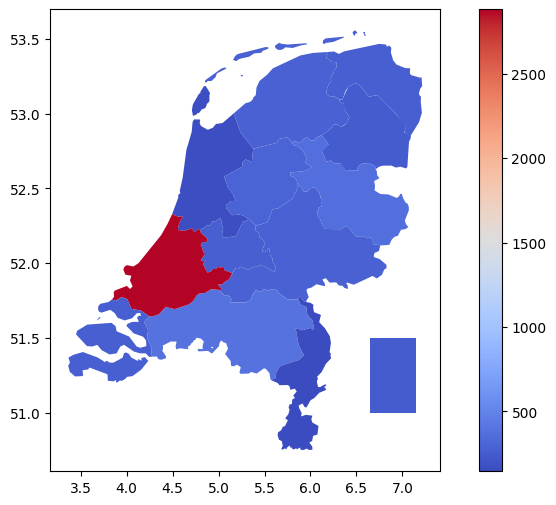

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Use the 'loss_gain' column to color the polygons
nl_nuts.plot(column="Loss/gain", ax=ax, legend=True, cmap="coolwarm")

In [31]:
Xbase_values = {
    (i, j): value(MRIA_RUN1.Xbase[i, j]) for i in MRIA_RUN1.m.r for j in MRIA_RUN1.m.S
}
Xbase_values.get(("NL33", "A01"))

7624.697078092194

In [32]:
xbase = list(MRIA_RUN1.Xbase)
xbase_val = list(MRIA_RUN1.Xbase.values())